In [31]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

### Change the currency

UPDATE order_payments
SET payment_value = payment_value / 535;

UPDATE order_items
SET price = price / 535,
	freight_value = freight_value / 535;


## The payment method that spend the most

SELECT SUM(payment_value)/COUNT(*) AS avg_order_value,
	COUNT(*) AS num_transactions,
	STDDEV(payment_value::numeric) AS std,
	payment_type
FROM order_payments
GROUP BY payment_type;

In [23]:
def mean_ci(mean, n_sample, std, name,alpha=0.05):
    st_err = std / np.sqrt(n_sample)
    z_crit = stats.norm.ppf(1 - alpha / 2)
    print(f'Mean of {name}: {round(mean - st_err*z_crit, 3)} — {round(mean, 3)} — {round(mean + st_err*z_crit, 3)}')


In [24]:
#Th:
mean_bol = 27.10
n_bol = 19784
std_bol = 39.92

mean_cc = 30.52
n_cc = 76795
std_cc = 41.52

mean_dc = 26.64
n_dc = 1529
std_dc = 45.94

mean_vc = 12.27
n_vc = 5775
std_vc = 21.59

#Calculations
mean_ci(mean_bol, n_bol, std_bol, name='Boleto',alpha=0.05)
mean_ci(mean_cc, n_cc, std_cc, name='Credit C.',alpha=0.05)
mean_ci(mean_dc, n_dc, std_dc, name='Debit C.',alpha=0.05)
mean_ci(mean_vc, n_vc, std_vc, name='Voucher',alpha=0.05)

Mean of Boleto: 26.544 — 27.1 — 27.656
Mean of Credit C.: 30.226 — 30.52 — 30.814
Mean of Debit C.: 24.337 — 26.64 — 28.943
Mean of Voucher: 11.713 — 12.27 — 12.827


In [25]:
print(f'Credit c. is {round(100*(30.226 - 27.656)/27.656, 1)}% more than boleto')
print(f'Credit c. is {round(100*(30.226 - 12.827)/12.827, 1)}% more than voucher')

Credit c. is 9.3% more than boleto
Credit c. is 135.6% more than voucher


### Findings:

Customers that use credit card spend 9,3% more than customers that use boleto... and 135.6% more than customers who use voucher.

## Brazilian state more prone to credit_card

WITH freq_table_all_cities AS (
	SELECT COUNT(*) AS frequency,
		customers.customer_state,
		payments.payment_type
	FROM orders
	LEFT JOIN customers ON orders.customer_id = customers.customer_id
	LEFT JOIN order_payments as payments ON payments.order_id = orders.order_id
	WHERE orders.order_status = 'delivered'
		AND payments.payment_type IN ('credit_card', 'boleto')
	GROUP BY customers.customer_state, payments.payment_type
	ORDER BY customers.customer_state
),

freq_table AS(
	SELECT *,
		SUM(frequency) OVER (PARTITION BY customer_state) AS tot_transactions
	FROM freq_table_all_cities
)

SELECT *
FROM freq_table
WHERE tot_transactions > 200;

## Satisfaction vs Delay delivery

WITH review_vs_delivery AS(
	SELECT
		EXTRACT(DAY FROM orders.order_estimated_delivery_date - orders.order_delivered_customer_date) AS days_in_advance,
		reviews.review_score
	FROM orders
	JOIN order_reviews AS reviews ON reviews.order_id = orders.order_id
	WHERE (orders.order_estimated_delivery_date - orders.order_delivered_customer_date) IS NOT NULL
)

SELECT
    CASE
        WHEN days_in_advance > 0 THEN 'early'
        WHEN days_in_advance = 0 THEN 'on_time'
        ELSE 'delay'
    END AS delivery_status,
	STDDEV(review_score) as std,
	COUNT(*) AS frequency,
    ROUND(AVG(review_score),2) AS average_review_score
FROM 
    review_vs_delivery
GROUP BY 
    CASE
        WHEN days_in_advance > 0 THEN 'early'
        WHEN days_in_advance = 0 THEN 'on_time'
        ELSE 'delay'
    END;

In [26]:
n_on_time = 2718
mean_on_time = 4.11
std_on_time = 1.2229379667062870

n_early = 86527
mean_early = 4.30
std_early = 1.1443707624508323

n_delay = 6362
mean_delay = 2.27
std_delay = 1.5708429336836291

mean_ci(mean_on_time, n_on_time, std_on_time, 'ON TIME')
mean_ci(mean_early, n_early, std_early, 'EARLY')
mean_ci(mean_delay, n_delay, std_delay, 'DELAY')

Mean of ON TIME: 4.064 — 4.11 — 4.156
Mean of EARLY: 4.292 — 4.3 — 4.308
Mean of DELAY: 2.231 — 2.27 — 2.309


In [29]:
print(f'Early vs. On time: +{round(100* (4.29-4.156)/4.156,1)}% satisfaction')
print(f'Early vs. Delay: +{round(100* (4.292-2.309)/2.309, 1)}% satisfaction')
print(f'On time vs. Delay: +{round(100* (4.064-2.309)/2.309, 1)}% satisfaction')

Early vs. On time: +3.2% satisfaction
Early vs. Delay: +85.9% satisfaction
On time vs. Delay: +76.0% satisfaction


WITH review_vs_delivery AS(
	SELECT
		EXTRACT(DAY FROM orders.order_estimated_delivery_date - orders.order_delivered_customer_date) AS days_in_advance,
		reviews.review_score
	FROM orders
	JOIN order_reviews AS reviews ON reviews.order_id = orders.order_id
	WHERE (orders.order_estimated_delivery_date - orders.order_delivered_customer_date) IS NOT NULL
),

reviews_delivery_bin AS(
	SELECT
		*,
		width_bucket(days_in_advance, -20, 20, 20) AS bin
	FROM review_vs_delivery
)

SELECT
	bin,
	MAX(days_in_advance) AS high_bound,
	MIN(days_in_advance) AS low_bound,
	AVG(review_score) AS avg_stars
FROM reviews_delivery_bin
GROUP BY bin
ORDER BY bin;

In [30]:
df = pd.read_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\data\ecom_brazil\4 tableau\review_score_vs_delivery.csv')
df.head()

,bin,high_bound,low_bound,avg_stars
0,0,-21,-188,1.768725
1,1,-19,-20,1.587500
2,2,-17,-18,1.672840
3,3,-15,-16,1.696000
4,4,-13,-14,1.654494


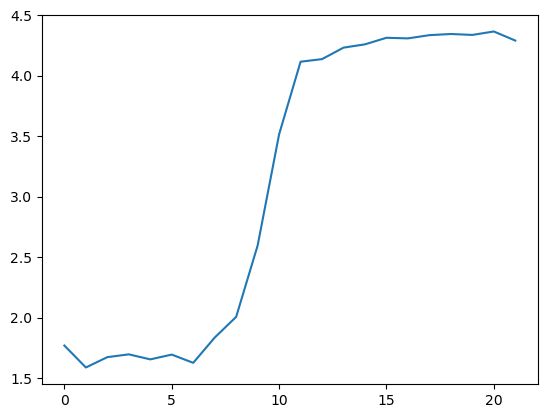

In [32]:
plt.plot(df['bin'], df['avg_stars'])

## Brazil and the tendency to buy locally

SELECT
	CASE
		 WHEN sellers.seller_city = customers.customer_city THEN 'km 0'
		 WHEN sellers.seller_state = customers.customer_state THEN 'local'
		 ELSE 'not local'
	END,
	COUNT(CASE
		 	WHEN sellers.seller_city = customers.customer_city THEN 'km 0'
		  	WHEN sellers.seller_state = customers.customer_state THEN 'local'
		 	ELSE 'not local'
		 END) AS frequency
FROM orders
LEFT JOIN order_items AS items ON items.order_id = orders.order_id
JOIN customers ON customers.customer_id = orders.customer_id
JOIN sellers ON sellers.seller_id = items.seller_id
GROUP BY CASE
		 	WHEN sellers.seller_city = customers.customer_city THEN 'km 0'
			WHEN sellers.seller_state = customers.customer_state THEN 'local'
		 	ELSE 'not local'
		 END;